This is an example Notebook for the PhotoReceptor model. Please run each cell in sequence. 

OPERATION:
- Run a cell by pressing the **Play** button (the black triangle) in the toolbar above.
- Note that the execution of a cell may take a while, and will be confirmed by a printout.
- To remove all printed output and figures, select **Cell/All Output/Clear** at the top.

TROUBLESHOOTING:
- If the output of a cell contains a warning (the box turns pink), re-run to see if it disappears. 
- If the warning does not go away when re-running, try to proceed with the next cells. 
- If further commands go wrong, select **Kernel/Restart** at the top.
- You can also re-start by selecting **File/Close and Halt**

In [1]:
###Load the PyPlot package
import PyPlot
println("PyPlot package loaded successfully")

PyPlot package loaded successfully


In the following cell, you can specify the number of parallel processes to run the MCMC with. The way to do this differs when running the notebook on a single computer vs. when running this notebook on a cluster of different computers (for more information on clusters see [Preparing an AWS Cluster](http://quantifyinguncertainty.github.io/#6-preparing-an-aws-cluster)).

1. To run the MCMC not in parallel (in a single Julia process), set RUNPARALLEL=false.

2. To run the MCMC in parallel on a single machine, set RUNPARALLEL=true and RUNONCLUSTER=false. You can set how many additional processes to run with by setting the NPROCS variable. It is recommended not to make NPROCS larger than the total number of CPU cores on your machine (defined by Julia global variable CPU_CORES).

3. When running this notebook on a cluster, set RUNPARALLEL=true and RUNONCLUSTER=true. Set the xxx.xxx.xxx.xxx values to the private IP addresses of the slave machines you have started (add as many **slaveip** entries to **machvec** as required).

In [2]:
RUNPARALLEL = true
RUNONCLUSTER = false

if RUNPARALLEL
    println("Starting additional Julia processes")
    NPROCS = min(16,CPU_CORES) #do not make larger than CPU_CORES
    if nprocs() < NPROCS
        addprocs(NPROCS-nprocs(),topology=:master_slave)
    end
    println("Number of Julia processes: ",nprocs())

    if RUNONCLUSTER 
        println("Starting additional Julia processes on the cluster")
        slaveip1 = "ubuntu@xxx.xxx.xxx.xxx"
        slaveip2 = "ubuntu@xxx.xxx.xxx.xxx"
        machvec = [(slaveip1,:auto),(slaveip2,:auto)]
        addprocs(machvec,topology=:master_slave)
        println("Total number of Julia processes in cluster: ",nprocs())
    end
end

Starting additional Julia processes
Number of Julia processes: 16


In [3]:
###Import first on the master process before importing on all slaves to avoid parallel race conditions
import GeneralizedMetropolisHastings
import GMHPhotoReceptor

###The following statement makes the GeneralizedMetropolisHastings core code available on all processes
@everywhere using GeneralizedMetropolisHastings
@everywhere using GMHPhotoReceptor

println("GMH modules loaded successfully")

GMH modules loaded successfully


If you want to change how many iterations are run, you can do so in the following box by changing
- nproposals: number of proposals evaluated in parallel in the Generalized Metropolis Hastings algorithm
- niterations: number of total iterations

In [4]:
#a single core performs between 50-60 model evaluations per second
#this can help you to estimate the overall time per iteration
#for instance, 100 proposals per process would make each iteration take about 2 seconds
nproposalsperprocess = 200 
nproposals = nproposalsperprocess*nworkers() #the more cores available, the more proposals we can execute in parallel

#MCMC iteration specifications
nburnin = 0
niterations = 100
ntunerperiod = 10

###Settings of the model
numvilli1 = 30000

#specify the values that determine the priors on the parameters
latencylocation = (2.0,3.5) #uniform distribution with (low,high) values
latencyscale = (0.2,0.7) #uniform distribution with (low,high) values
refractorylocation = (4.0,6.0) #uniform distribution with (low,high) values
refractoryscale = (1.5,2.5) #uniform distribution with (low,high) values
bumpamplitude = (3.0,5.0) #uniform distribution with (low,high) values
bumpshape = (log(3.0),0.3) #lognormal distribution with (location,scale) values; variable can vary roughly between 2.0 and 4.0, but becomes increasingly penalized outside
bumpscale = (log(2.5),0.3) #lognormal distribution with (location,scale) values; variable can vary roughly between 1.5 and 3.5, but becomes increasingly penalized outside

photonfilename = "../data/naturallight.jld"
photons1 = photonsequence(photonfilename)
current1 = lightinducedcurrent(photonfilename)

modelpolicy1 = policy(:photoreceptor) #4-parameter model with stochastic lognormal latency and refractory parameters and fixed bump parameters
params1 = parameters(:photoreceptor,modelpolicy1,latencylocation,latencyscale,refractorylocation,refractoryscale)

####Variance for a normal, additive noise model, estimated from previous runs
variance1 = [3600.0]

println("==========================================")
println("Simulation parameters defined successfully")
println("==========================================")

Simulation parameters defined successfully


In [5]:
###Create a PhotoReceptor model
model1 = model(:photoreceptor,params1,photons1,current1,variance1,numvilli1,modelpolicy1)

###Show the model
println("==========================")
println("Model defined successfully")
println("==========================")
show(model1)

Model defined successfully
Model PhotoReceptorModel
parameters: Array{AbstractParameter} with
[1] ParameterUnivariate
 key: latencylocation
 prior: Distributions.Uniform(a=2.0, b=3.5)
 default: 2.75
[2] ParameterUnivariate
 key: latencyscale
 prior: Distributions.Uniform(a=0.2, b=0.7)
 default: 0.44999999999999996
[3] ParameterUnivariate
 key: refractorylocation
 prior: Distributions.Uniform(a=4.0, b=6.0)
 default: 5.0
[4] ParameterUnivariate
 key: refractoryscale
 prior: Distributions.Uniform(a=1.5, b=2.5)
 default: 2.0
photons: DataArray with 1 variable and 2100 values
 index: Array{Float32,1}
 values: Array{Int64,1}
measurements: DataArray with 1 variable and 2100 values
 index: Array{Float32,1}
 values: Array{Float64,1}
noisemodel: Gaussian Noise Model
 variance: Array{Float64,1}
 distributions: Array{Distributions.Normal,1}
policy: PhotoReceptorPolicy with traits:
  latency = lognormal
  refractory = lognormal
  bump = fixed
  FixedBumpShapeParameters with values:
    amplitude = 

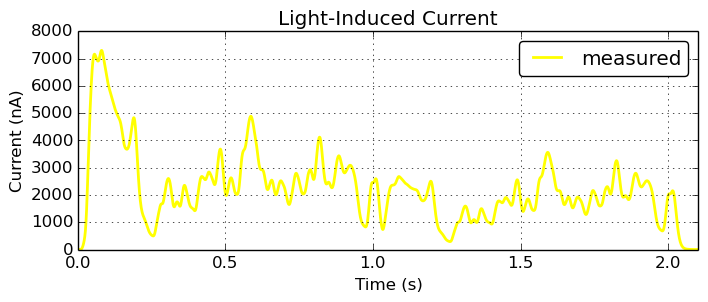

PyObject <matplotlib.legend.Legend object at 0x7f12309d6550>

In [6]:
###Plot the measurement data
PyPlot.figure("PhotoReceptor1") ; PyPlot.clf()
PyPlot.subplot(211)
PyPlot.plot(dataindex(model1),measurements(model1);label="measured",linewidth=2,color="yellow")
PyPlot.xlabel("Time (s)")
PyPlot.ylabel("Current (nA)")
PyPlot.xlim(dataindex(model1)[1],dataindex(model1)[end])
PyPlot.title("Light-Induced Current")
PyPlot.grid("on")
PyPlot.legend(loc="upper right",fancybox="true")

Evaluating the model 100 times


4-element Array{Float64,1}:
 2.58447 
 0.559876
 4.09175 
 2.47148 

Evaluation paramater values: 


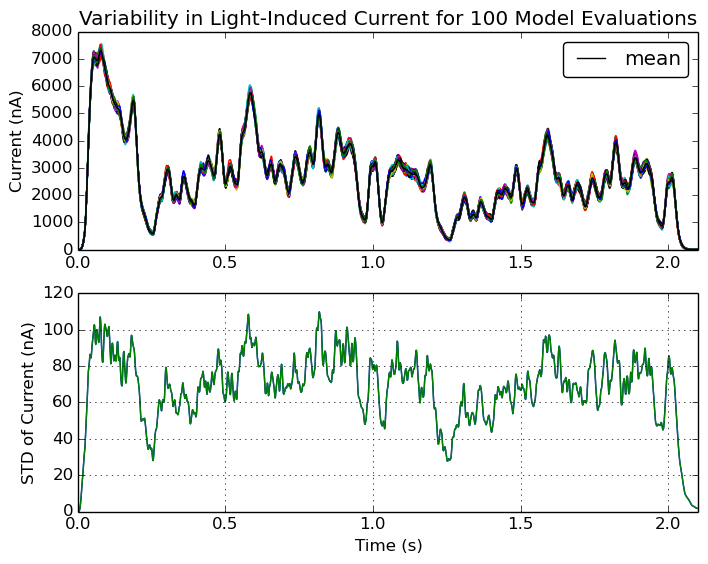

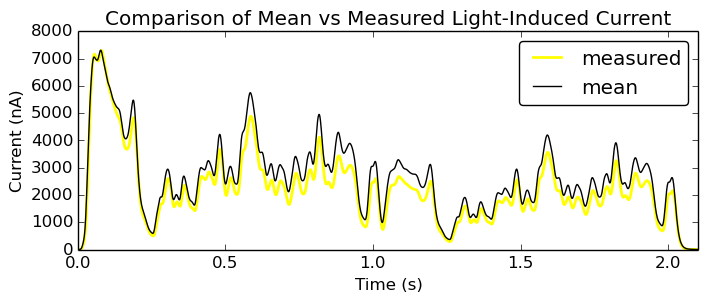

Mean Log-Posterior for these parameters: -72101.24670839756


In [7]:
###Evaluate the model for a set of random parameter values and plot the fit
###You can execute this cell as many times as you like
###Parameter values are drawn from the prior distributions on the parameters
numevaluations = 100
paramvals = GeneralizedMetropolisHastings.initvalues!(trait(:initialize,:prior),params1,zeros(Float64,length(params1)))
println("Evaluating the model $numevaluations times")
evaldata = evaluate!(model1,paramvals,numevaluations)
logposteriorvals = zeros(numevaluations)
for i=1:numevaluations
    logposteriorvals[i] = loglikelihood(model1,evaldata[:,i])+logprior(params1,paramvals,Float64)
end
meanevaldata = mean(evaldata,2)
stdevaldata = std(evaldata,2)

PyPlot.figure("PhotoReceptor Model Evaluations")
PyPlot.subplot(211)
PyPlot.plot(dataindex(model1),evaldata)
PyPlot.plot(dataindex(model1),meanevaldata;label="mean",linewidth=1,color="black")
PyPlot.xlim(dataindex(model1)[1],dataindex(model1)[end])
PyPlot.legend(loc="upper right",fancybox="true")
PyPlot.ylabel("Current (nA)")
PyPlot.title("Variability in Light-Induced Current for 100 Model Evaluations")
PyPlot.subplot(212)
PyPlot.plot(dataindex(model1),stdevaldata)
PyPlot.plot(dataindex(model1),mean(stdevaldata,2),linewidth=1)
PyPlot.xlim(dataindex(model1)[1],dataindex(model1)[end])
PyPlot.xlabel("Time (s)")
PyPlot.ylabel("STD of Current (nA)")
PyPlot.grid("on")

PyPlot.figure("PhotoReceptor Measured vs Model Fit")
PyPlot.subplot(211)
PyPlot.plot(dataindex(model1),measurements(model1);label="measured",linewidth=2,color="yellow")
PyPlot.plot(dataindex(model1),meanevaldata;label="mean",linewidth=1,color="black")
PyPlot.xlim(dataindex(model1)[1],dataindex(model1)[end])
PyPlot.xlabel("Time (s)")
PyPlot.ylabel("Current (nA)")
PyPlot.legend(loc="upper right",fancybox="true")
PyPlot.title("Comparison of Mean vs Measured Light-Induced Current")

println("Evaluation paramater values: ")
display(paramvals)
println("Mean Log-Posterior for these parameters: ",mean(logposteriorvals))

In [8]:
###Create a sampler, either a Metropolis sampler with normal proposal density
###or an Adaptive Metropolis sampler with normal proposal density
#sampler1 = sampler(:mh,:normal,0.001,4)
sampler1 = sampler(:adaptive,0.0001,4)
println("============================")
println("Sampler defined successfully")
println("============================")
show(sampler1)

###Create a tuner that scales the proposal density
#tuner1 = tuner(:scale,ntunerperiod,0.5,:erf) #use for Metropolis sampler
tuner1 = tuner(:monitor,ntunerperiod) #use for Adaptive Metropolis sampler
println("==========================")
println("Tuner defined successfully")
println("==========================")
show(tuner1)

###Create a Generalized Metropolis-Hastings runner (which will default to Standard MH when nproposals=1)
runnerpolicy1 = policy(:mh,nproposals;initialize=:prior)
runner1 = runner(runnerpolicy1,niterations,nproposals;numburnin = nburnin)
println("===========================")
println("Runner defined successfully")
println("===========================")
show(runner1)

Sampler defined successfully
Adaptive Normal Metropolis Sampler with fields:
  [:initialscalefactor,:nparas]
Tuner defined successfully
MonitorTuner: period = 10, verbose = true
Runner defined successfully
Generalized Metropolis-Hastings runner with:
 numburnin: 0
 numiterations: 100
 numproposals: 3000
 numindicatorsamples: 3000
 policy: MHRuntimePolicy with traits:
  runner = generalized
  initialize = prior
  propose = auxiliary
  indicator = stationary
  jobsegments = workers
  chain = standard
  store = main
  sampletype = Float64
  calculationtype = Float64




In [9]:
###Run the MCMC (can take quite a bit of time)
println("=======================")
println("Run the MCMC simulation")
println("=======================")
@time chain1 = run!(runner1,model1,sampler1,tuner1)
println("=========================")
println("Completed MCMC simulation")
println("=========================")

Run the MCMC simulation
RemoteSegments with 15 segments and 200 proposals per segment.
Additional fields: :remote, :collectedsamples, :prop2collected
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
Iteration 100/100
505.590724 seconds (15.99 M allocations: 537.796 MB, 0.04% gc time)
Completed MCMC simulation


In [10]:
###Show the result of the simulations
show(chain1)

nparas = numparas(model1)
meanparamvals = mean(samples(chain1),2)
stdparamvals = std(samples(chain1),2)

println("Results of the MCMC simulation:")
for i=1:nparas
    println("mean $(parameters(model1)[i].key): $(meanparamvals[i])")
    println("std $(parameters(model1)[i].key): $(stdparamvals[i])")
end

ChainStandard with numparas = 4 and numsamples = 300000
Samples proposed = 300000, samples accepted = 9, acceptance rate = 3.0e-5
Total runtime = 502.46388065
Additional fields: :values, :loglikelihood
Results of the MCMC simulation:
mean latencylocation: 2.615952168104082
std latencylocation: 0.005355580565016388
mean latencyscale: 0.4364317090563782
std latencyscale: 0.0009008127738599992
mean refractorylocation: 4.907159166508663
std refractorylocation: 0.009918310994175956
mean refractoryscale: 2.2173643984177613
std refractoryscale: 0.004467267477767229


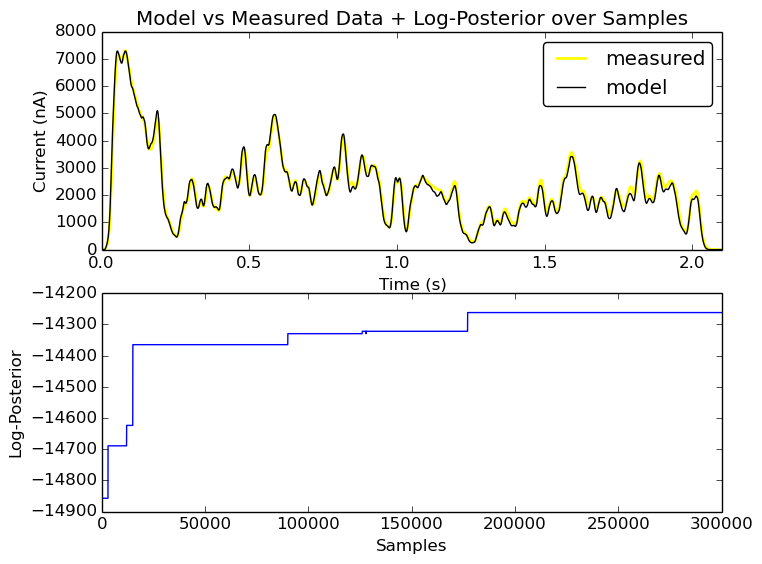

Plotting results


PyObject <matplotlib.text.Text object at 0x7f1230369c10>

In [11]:
println("================")
println("Plotting results")
println("================")

###Plot the average model results in the data window
PyPlot.figure()
modeldata = evaluate!(model1,vec(meanparamvals))
PyPlot.subplot(211)
PyPlot.plot(dataindex(model1),measurements(model1);label="measured",linewidth=2,color="yellow")
PyPlot.plot(dataindex(model1),modeldata;label="model",linewidth=1,color="black")
PyPlot.xlim(dataindex(model1)[1],dataindex(model1)[end])
PyPlot.xlabel("Time (s)"); PyPlot.ylabel("Current (nA)")
PyPlot.legend(loc="upper right",fancybox="true")
PyPlot.title("Model vs Measured Data + Log-Posterior over Samples")

###Plot the logposterior values across samples
PyPlot.subplot(212)
PyPlot.plot(1:numsamples(chain1),logposterior(chain1,model1))
PyPlot.xlabel("Samples")
PyPlot.ylabel("Log-Posterior")

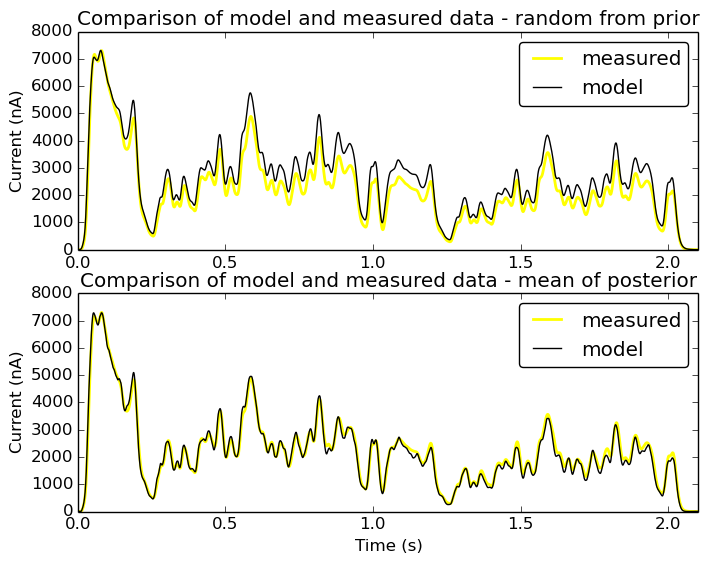

PyObject <matplotlib.text.Text object at 0x7f1230450f10>

In [12]:
PyPlot.figure()
PyPlot.subplot(211)
PyPlot.plot(dataindex(model1),measurements(model1);label="measured",linewidth=2,color="yellow")
PyPlot.plot(dataindex(model1),meanevaldata;label="model",linewidth=1,color="black")
PyPlot.xlim(dataindex(model1)[1],dataindex(model1)[end])
PyPlot.ylabel("Current (nA)")
PyPlot.legend(loc="upper right",fancybox="true")
PyPlot.title("Comparison of model and measured data - random from prior")
PyPlot.subplot(212)
PyPlot.plot(dataindex(model1),measurements(model1);label="measured",linewidth=2,color="yellow")
PyPlot.plot(dataindex(model1),modeldata;label="model",linewidth=1,color="black")
PyPlot.xlim(dataindex(model1)[1],dataindex(model1)[end])
PyPlot.xlabel("Time (s)")
PyPlot.ylabel("Current (nA)")
PyPlot.legend(loc="upper right",fancybox="true")
PyPlot.title("Comparison of model and measured data - mean of posterior")

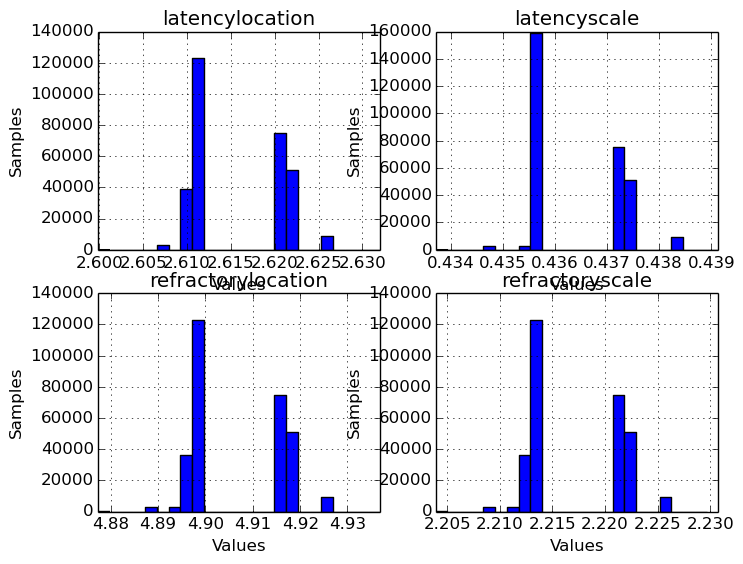

In [13]:
for i=1:nparas
    PyPlot.subplot(220 + i)
    leftlim = meanparamvals[i]-3*stdparamvals[i]
    rightlim = meanparamvals[i]+3*stdparamvals[i]
    binsize = stdparamvals[i]/4
    bins = leftlim:binsize:rightlim
    h = PyPlot.plt[:hist](sub(samples(chain1),i,:)',bins)
    PyPlot.grid("on")
    PyPlot.title("$(parameters(model1)[i].key)")
    PyPlot.xlabel("Values")
    PyPlot.ylabel("Samples")
    PyPlot.xlim([leftlim,rightlim])
end

In [ ]:
###Only run this box if you want to shut down all worker processes
println("Pre processes running: ",procs())
rmprocs(workers())
println("Post processes running: ",procs())